# SmartRecs — Personalized Media Recommendation System using Collaborative Filtering

This notebook implements a hybrid movie recommendation system using IMDb datasets. It combines **genre-based similarity** (content filtering) and **SVD-based collaborative filtering** to deliver personalized top-N movie suggestions.

We use fuzzy title matching for better user experience, cosine similarity for genre closeness, and matrix factorization to simulate user ratings. The solution reflects the project described in the submitted proposal and can be extended to similar domains like anime, series, or other digital media.

## 1. Install Dependencies

We use the following libraries:
- `pandas`, `numpy`: for data manipulation
- `scikit-learn`: for TF-IDF vectorization and cosine similarity
- `surprise`: for SVD-based collaborative filtering
- `difflib`: for fuzzy title matching

In [2]:
# Install the Surprise library for collaborative filtering
!pip install scikit-surprise

# Optional: Install Levenshtein for faster fuzzy matching (optional)
# !pip install python-Levenshtein

## 2. Load IMDb Data

We load and clean two IMDb datasets:
- `title.basics.tsv`: contains metadata like `tconst`, `primaryTitle`, `genres`, `startYear`, `isAdult`
- `title.ratings.tsv`: contains `averageRating` and `numVotes` per title

We perform the following steps:
- Filter only feature films (`titleType == 'movie'`)
- Remove adult content (`isAdult == 0`)
- Ensure movies have valid genres, titles, and release year ≥ 1980
- Join with ratings and retain only those with ≥ 1000 votes

The final DataFrame is stored in `movies_filtered`.

In [3]:
import pandas as pd

# Define the path to IMDb TSV files (adjust for local, Kaggle, or Colab use)
base_path = '/kaggle/input/imdb-ratings-and-basics-tsv/'

# Load IMDb basics dataset (titles, genres, etc.) with missing value handling
basics = pd.read_csv(base_path + 'title.basics.tsv', sep='\t', na_values='\\N', low_memory=False)

# Load IMDb ratings dataset (average rating and number of votes)
ratings = pd.read_csv(base_path + 'title.ratings.tsv', sep='\t', na_values='\\N')

# Clean column names by stripping whitespace and special characters
basics.columns = [str(col).strip() for col in basics.columns]
ratings.columns = [str(col).strip() for col in ratings.columns]

# Convert 'isAdult' column to float for filtering (to handle any missing values safely)
basics['isAdult'] = basics['isAdult'].astype(float)

# Filter: Keep only non-adult feature films with valid metadata
movies_filtered = basics[
    (basics['titleType'] == 'movie') &
    (basics['isAdult'] == 0) &
    (basics['startYear'].notna()) &
    (basics['genres'].notna()) &
    (basics['primaryTitle'].notna())
].copy()

# Merge movie metadata with ratings on 'tconst'
movies_filtered = movies_filtered.merge(ratings, on='tconst')

# Further filter: Keep movies from year >= 1980 with at least 1000 votes
movies_filtered = movies_filtered[
    (movies_filtered['startYear'].astype(int) >= 1980) &
    (movies_filtered['numVotes'].astype(int) >= 1000)
].copy()

# Reset index for consistency with later matrix operations
movies_filtered = movies_filtered.reset_index(drop=True)

# Print resulting shape and column names for verification
print("Final movies_filtered shape:", movies_filtered.shape)
print("Columns:", movies_filtered.columns.tolist())

Final movies_filtered shape: (37640, 11)
Columns: ['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes']


## 3. Genre-Based Similarity (Cosine TF-IDF)

To compute genre similarity:
- Convert the `genres` column into text
- Use `TfidfVectorizer` to create a TF-IDF matrix
- Use `cosine_similarity` to compute pairwise closeness between movie vectors

This enables content-based recommendations even when rating data is sparse.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Convert genre strings to a space-separated format for TF-IDF input
# Example: "Action,Comedy,Drama" → "Action Comedy Drama"
movies_filtered['genre_str'] = movies_filtered['genres'].fillna('').apply(lambda x: x.replace(',', ' '))

# Create a TF-IDF matrix based on the genre strings
tfidf = TfidfVectorizer()
genre_matrix = tfidf.fit_transform(movies_filtered['genre_str'])

# Compute pairwise cosine similarity between movies based on genre vectors
genre_similarity = cosine_similarity(genre_matrix)

## 4. EDA (Optional Visualizations)

This step is optional but useful to understand trends in the dataset.

Example visualizations:
- Distribution of movie ratings
- Most frequent genres
- Relationship between rating and number of votes

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


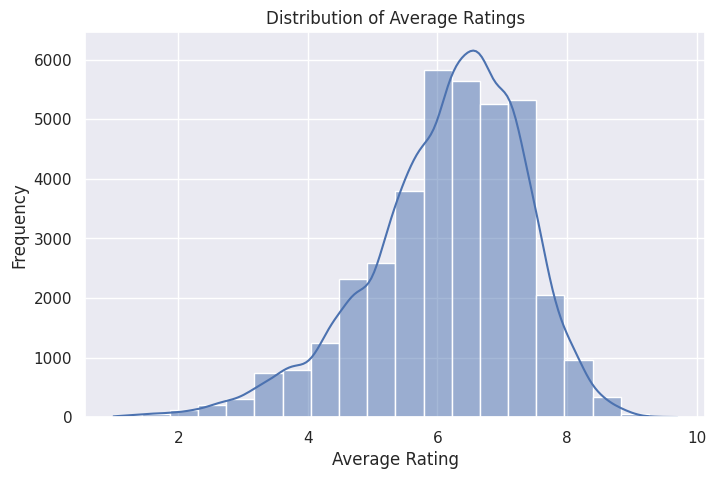

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


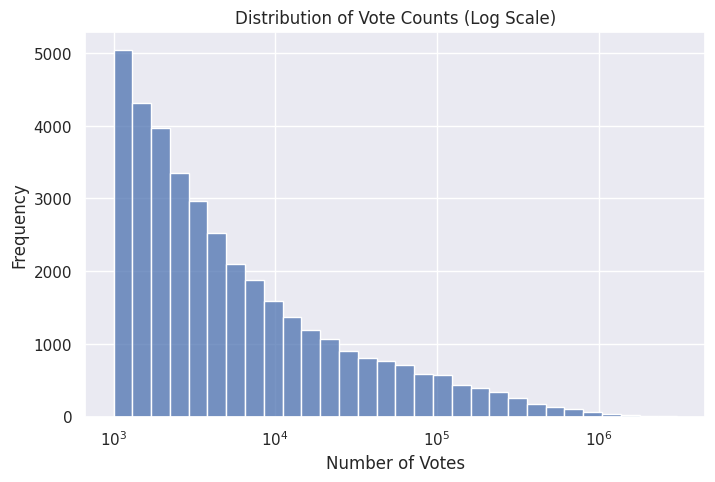

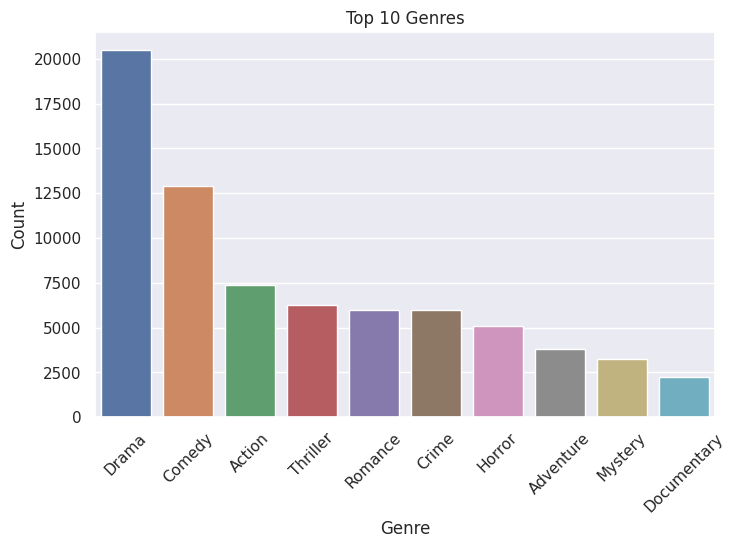

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set Seaborn theme for consistent visual style
sns.set(style="darkgrid")

# Plot: Distribution of average movie ratings
plt.figure(figsize=(8, 5))
sns.histplot(movies_filtered['averageRating'], bins=20, kde=True)
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

# Plot: Distribution of vote counts (log scale)
plt.figure(figsize=(8, 5))
sns.histplot(movies_filtered['numVotes'], bins=30, log_scale=True)
plt.title('Distribution of Vote Counts (Log Scale)')
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.show()

# Plot: Top 10 most frequent genres
# Flatten all genre lists into one combined list
genre_list = []
for g in movies_filtered['genres'].dropna():
    genre_list.extend(g.split(','))

# Count genre frequency
top_genres = pd.DataFrame(Counter(genre_list).most_common(10), columns=['Genre', 'Count'])

# Bar plot of top genres
plt.figure(figsize=(8, 5))
sns.barplot(data=top_genres, x='Genre', y='Count')
plt.title('Top 10 Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## 5. Train SVD (Collaborative Filtering)

We use the `Surprise` library to train a matrix factorization model:
- Build a user-item rating matrix using `Dataset.load_from_df()`
- Apply **Singular Value Decomposition (SVD)** to learn latent features
- Predict ratings for unseen movie-user combinations

This provides the collaborative filtering backbone of the system.

In [6]:
from surprise import SVD, Dataset, Reader

# Prepare the data for collaborative filtering using Surprise
# Note: Since we don't have real users, we simulate user IDs using 'tconst' (IMDb title ID),
# and treat 'primaryTitle' as the item being rated.

svd_data = pd.DataFrame({
    'userID': movies_filtered['tconst'],          # Simulated users (each movie acts as a user)
    'itemID': movies_filtered['primaryTitle'],    # Items are movie titles
    'rating': movies_filtered['averageRating']    # Use average IMDb rating as the score
})

# Define the reader to specify the rating scale
reader = Reader(rating_scale=(1, 10))

# Load the data into Surprise format
data = Dataset.load_from_df(svd_data[['userID', 'itemID', 'rating']], reader)
trainset = data.build_full_trainset()

# Train the SVD model on the full dataset
svd = SVD()
svd.fit(trainset)

## 6. Genre-Aware Filter Function

This function enhances recommendations by excluding undesired genres.

Key features:
- Removes irrelevant or undesired genres (e.g., `Horror`)
- Ensures returned results are thematically close to the input movie
- Helps control content tone for users with specific preferences

In [7]:
def filter_by_genre(input_genres, df, genre_column='genres', exclude_genres=None, min_common=1):
    """
    Filters a DataFrame of movies based on genre similarity and optional exclusions.

    Parameters:
        input_genres (list): List of genres to match against.
        df (DataFrame): The movie DataFrame to filter.
        genre_column (str): Name of the column containing genre strings.
        exclude_genres (list or None): Genres to explicitly exclude (e.g., ['Horror']).
        min_common (int): Minimum number of shared genres required to keep a movie.

    Returns:
        DataFrame: Filtered DataFrame with movies matching genre criteria.
    """
    filtered = df.copy()

    # Convert genre strings to lists
    filtered['genre_list'] = filtered[genre_column].apply(
        lambda x: x.split(',') if pd.notnull(x) else []
    )

    # Exclude movies that contain any genres in the exclude list
    if exclude_genres:
        filtered = filtered[
            ~filtered['genre_list'].apply(
                lambda g: any(ex in g for ex in exclude_genres)
            )
        ]

    # Keep movies that share at least `min_common` genres with the input
    filtered = filtered[
        filtered['genre_list'].apply(
            lambda g: len(set(input_genres).intersection(set(g))) >= min_common
        )
    ]

    return filtered

## 7. Final Hybrid Recommendation Function

This is the main function that powers the recommender.

Features:
- Accepts partial or full movie title
- Uses fuzzy and substring matching to identify candidate movies
- Combines:
  - **60% SVD-predicted rating**
  - **40% genre cosine similarity**
- Excludes duplicate and horror entries by default
- Displays a ranked table of top-N recommended movies with title, year, genres, and score

In [8]:
import difflib
from sklearn.metrics.pairwise import cosine_similarity

def get_smart_title_options(input_title, df, n=10):
    """
    Returns a list of movies whose titles match the input string
    using substring match first, and fuzzy match as fallback.

    Parameters:
        input_title (str): Movie title input by the user.
        df (DataFrame): The movie dataset (must include 'primaryTitle').
        n (int): Number of matches to return.

    Returns:
        DataFrame: Top n matching movies with columns: primaryTitle, startYear, genres.
    """
    input_lower = input_title.lower()
    df.columns = df.columns.str.strip()

    if 'primaryTitle' not in df.columns:
        raise KeyError("The dataframe must contain 'primaryTitle' column.")

    # First try substring match
    substring_matches = df[df['primaryTitle'].str.lower().str.contains(input_lower, na=False)]
    if not substring_matches.empty:
        return substring_matches[['primaryTitle', 'startYear', 'genres']].drop_duplicates().head(n).reset_index(drop=True)

    # Fallback to fuzzy match
    all_titles = df['primaryTitle'].dropna().tolist()
    matches = difflib.get_close_matches(input_lower, [t.lower() for t in all_titles], n=n, cutoff=0.6)
    fuzzy_rows = df[df['primaryTitle'].str.lower().isin(matches)]

    return fuzzy_rows[['primaryTitle', 'startYear', 'genres']].drop_duplicates().head(n).reset_index(drop=True)


def hybrid_recommend(movie_input, top_n=10):
    """
    Hybrid recommendation system that combines collaborative filtering (SVD)
    with genre-based cosine similarity to generate top-N recommendations.
    """
    # Step 1: Clean column names and find matching title options
    movies_filtered.columns = [str(col).strip() for col in movies_filtered.columns]
    options = get_smart_title_options(movie_input, movies_filtered)

    if options.empty:
        print(f"\nNo close match found for '{movie_input}'. Try another title.\n")
        return []

    print("\nDid you mean one of these?")
    for i, row in options.iterrows():
        print(f"  {i}: {row['primaryTitle']} ({row['startYear']}, {row['genres']})")

    # Step 2: Ask user to select the correct match
    try:
        selected_index = int(input("\nEnter the number of the correct movie: "))
        if selected_index < 0 or selected_index >= len(options):
            print("Invalid selection.")
            return []
    except:
        print("Invalid input.")
        return []

    selected_row = options.iloc[selected_index]
    chosen_title = selected_row['primaryTitle']
    chosen_year = selected_row['startYear']
    print(f"\nShowing recommendations based on: {chosen_title}\n")

    # Step 3: Locate the selected movie in the full dataset
    match = movies_filtered[
        (movies_filtered['primaryTitle'] == chosen_title) &
        (movies_filtered['startYear'] == chosen_year)
    ]
    if match.empty:
        print("Selected movie not found in dataset.")
        return []

    idx = match.index[0]
    input_genres = movies_filtered.loc[idx, 'genres'].split(',')
    title_tconst = movies_filtered.loc[idx, 'tconst']

    # Step 4: Compute genre similarity scores
    sim_scores = list(enumerate(genre_similarity[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_indices = [i for i, score in sim_scores if i != idx]
    candidates = movies_filtered.iloc[sim_indices]

    # Step 5: Filter candidates based on genre (exclude Horror)
    candidates = filter_by_genre(input_genres, candidates, exclude_genres=['Horror'])

    # Step 6: Compute hybrid scores (SVD + genre similarity)
    hybrid_scores = []
    for _, row in candidates.iterrows():
        try:
            svd_score = svd.predict(title_tconst, row['primaryTitle']).est
        except:
            svd_score = 0
        try:
            genre_score = cosine_similarity(
                genre_matrix[idx].reshape(1, -1),
                genre_matrix[row.name].reshape(1, -1)
            )[0][0]
        except:
            genre_score = 0

        final_score = 0.6 * svd_score + 0.4 * genre_score
        hybrid_scores.append((row['primaryTitle'], final_score))

    # Step 7: Sort and remove duplicates
    top_recommendations = sorted(hybrid_scores, key=lambda x: x[1], reverse=True)
    seen = set()
    unique_recommendations = []
    for title, score in top_recommendations:
        if title not in seen:
            seen.add(title)
            unique_recommendations.append((title, score))
        if len(unique_recommendations) >= top_n:
            break

    # Step 8: Display the final recommendations
    print("\nTop Recommendations:\n")
    print(f"{'Title':<52} {'Year':<6} {'Genres':<40} {'Score'}")
    print("-" * 110)

    for title, score in unique_recommendations:
        try:
            details = movies_filtered[movies_filtered['primaryTitle'] == title].iloc[0]
            year = details['startYear']
            genres = details['genres']
            print(f"{title:<52} {str(year):<6} {genres:<40} {round(score, 2)}")
        except:
            print(f"{title:<52} {'-':<6} {'-':<40} {round(score, 2)}")

    print("\nRecommendation complete.\n")

## 8. Try It Out

This section allows you to test the hybrid recommendation system in two modes:

1. **Automated Mode (Kaggle-Safe)**  
   Useful for demos or saving in platforms like Kaggle where live input is not supported.  
   - Uses a predefined list of movie titles
   - Randomly selects one for testing
   - Automatically proceeds without asking the user if only one match is found

2. **Interactive Mode (Live Input)**  
   For running the system live with manual input. The user:
   - Enters a movie title
   - Chooses from close matches if multiple are found
   - Receives top 10 hybrid recommendations based on their selection

> Tip: Before saving the notebook (especially on Kaggle), comment out the **interactive** cell to prevent errors. Use the **automated** version instead.

### 8.1 Test Recommender in Kaggle with Random Movie Title

Kaggle cannot run interactive `input()` prompts. This block selects a random movie from a predefined list and automatically runs the recommendation pipeline.

> **Comment out this entire block before running live input in Section 8.2.**

In [9]:
# # This entire block should be COMMENTED OUT when using live input in 8.2

# import random

# # Function to run the recommender without user input (for Kaggle)
# def run_recommender_safely(title):
#     options = get_smart_title_options(title, movies_filtered)

#     if options.empty:
#         print(f"No close match found for '{title}'")
#         return

#     # Automatically select index 0 (first match)
#     selected_index = 0

#     selected_row = options.iloc[selected_index]
#     chosen_title = selected_row['primaryTitle']
#     chosen_year = selected_row['startYear']
#     print(f"\nRunning recommendation for: {chosen_title} ({chosen_year})")

#     match = movies_filtered[
#         (movies_filtered['primaryTitle'] == chosen_title) &
#         (movies_filtered['startYear'] == chosen_year)
#     ]
#     if match.empty:
#         print("Movie not found.")
#         return

#     idx = match.index[0]
#     input_genres = movies_filtered.loc[idx, 'genres'].split(',')
#     title_tconst = movies_filtered.loc[idx, 'tconst']

#     sim_scores = list(enumerate(genre_similarity[idx]))
#     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#     sim_indices = [i for i, score in sim_scores if i != idx]
#     candidates = movies_filtered.iloc[sim_indices]
#     candidates = filter_by_genre(input_genres, candidates, exclude_genres=['Horror'])

#     hybrid_scores = []
#     for _, row in candidates.iterrows():
#         try:
#             svd_score = svd.predict(title_tconst, row['primaryTitle']).est
#         except:
#             svd_score = 0
#         try:
#             genre_score = cosine_similarity(
#                 genre_matrix[idx].reshape(1, -1),
#                 genre_matrix[row.name].reshape(1, -1)
#             )[0][0]
#         except:
#             genre_score = 0
#         final_score = 0.6 * svd_score + 0.4 * genre_score
#         hybrid_scores.append((row['primaryTitle'], final_score))

#     top_recommendations = sorted(hybrid_scores, key=lambda x: x[1], reverse=True)
#     seen = set()
#     unique_recommendations = []
#     for title, score in top_recommendations:
#         if title not in seen:
#             seen.add(title)
#             unique_recommendations.append((title, score))
#         if len(unique_recommendations) >= 10:
#             break

#     print("\nTop Recommendations:\n")
#     print(f"{'Title':<52} {'Year':<6} {'Genres':<40} {'Score'}")
#     print("-" * 110)

#     for title, score in unique_recommendations:
#         try:
#             details = movies_filtered[movies_filtered['primaryTitle'] == title].iloc[0]
#             year = details['startYear']
#             genres = details['genres']
#             print(f"{title:<52} {str(year):<6} {genres:<40} {round(score, 2)}")
#         except:
#             print(f"{title:<52} {'-':<6} {'-':<40} {round(score, 2)}")

#     print("\nRecommendation complete.\n")

# # Choose a random movie title from test set
# test_titles = [
#     "cars", "inception", "toy story", "the matrix", "forrest gump",
#     "la la land", "finding nemo", "spider man", "your name", "moonlight",
#     "interstellar", "the dark knight", "slumdog millionaire", "titanic", "parasite",
#     "the lion king", "avengers", "coco", "joker", "life of pi",
#     "up", "shrek", "eternal sunshine of the spotless mind", "the social network", "mad max",
#     "inside out", "whiplash", "the grand budapest hotel", "1917", "the shawshank redemption"
# ]

# random_title = random.choice(test_titles)
# print(f"Selected test title: {random_title}")
# run_recommender_safely(random_title)

### 8.2 Live Input (Manual Testing)

Use this block when running the notebook interactively (Jupyter, Colab, etc.).  
It will ask you to type a movie name and select a match manually from the suggested options.

> **Comment out this block when running in Kaggle or exporting the notebook, as Kaggle does not support `input()` prompts and will throw an error.**

In [13]:
# === Live Input Version ===
# Use this when running interactively (Jupyter/Colab)

# This block should be COMMENTED OUT when exporting or running in Kaggle
# because Kaggle does not support interactive input()

# Uncomment the two lines below to test manually:
user_input = input("Enter a movie name: ")
hybrid_recommend(user_input)


Enter a movie name:  thor



Did you mean one of these?
  0: Author! Author! (1982.0, Comedy,Drama,Family)
  1: The Lighthorsemen (1987.0, Drama,History,War)
  2: The Wild Thornberrys (2002.0, Adventure,Animation,Comedy)
  3: Bathory: Countess of Blood (2008.0, Biography,Drama,Fantasy)
  4: Thor (2011.0, Action,Fantasy)
  5: Thor: Love and Thunder (2022.0, Action,Adventure,Comedy)
  6: Thor: Legend of the Magical Hammer (2011.0, Adventure,Animation,Comedy)
  7: Mapplethorpe (2018.0, Biography,Drama)
  8: Under the Hawthorne Tree (2010.0, Drama,Romance)
  9: Blackthorn (2011.0, Action,Adventure,Drama)



Enter the number of the correct movie:  5



Showing recommendations based on: Thor: Love and Thunder


Top Recommendations:

Title                                                Year   Genres                                   Score
--------------------------------------------------------------------------------------------------------------
Mother                                               1990.0 Drama                                    4.29
Avane Srimannarayana                                 2019.0 Action,Adventure,Comedy                  4.28
Aditya 369                                           1991.0 Action,Adventure,Comedy                  4.28
Spider-Man: Far from Home                            2019.0 Action,Adventure,Comedy                  4.26
Turbo Kid                                            2015.0 Action,Adventure,Comedy                  4.26
Sportloto-82                                         1982.0 Action,Adventure,Comedy                  4.26
The Jewel of the Nile                                1985.0 Acti